## Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#vectorizers
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, recall_score, plot_confusion_matrix
from sklearn.decomposition import PCA
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
#import xgboost as xg
from sklearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.utils import class_weight

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.feature_selection import RFE
from statsmodels.stats.outliers_influence import OLSInfluence as influence

In [3]:
def scores(model, X, y, set_type, return_conf=False):
    '''
    This function takes in an already fitted model, X, y, and
    the type of data (train, validation, or test) in str format,
    and prints out the accuracy and recall scores. The function
    also prints out the confusion matrix
    '''
    pred = model.predict(X)
    acc_score = accuracy_score(y, pred)
    rec_score = recall_score(y, pred)
    
    print("{} Scores".format(set_type))
    print("accuracy: ", acc_score)
    print("recall:   ", rec_score)
    fig, ax = plt.subplots(figsize=(6,6))
    #set background color to white
    fig.patch.set_facecolor('white')
    ax.set_title(set_type)
    plot_confusion_matrix(model, X, y, ax=ax)
    if return_conf == True:
        return fig, round(acc_score*100,1), round(rec_score*100,1)
    if return_conf == False:
        return round(acc_score*100,1), round(rec_score*100,1)

In [4]:
def cross_val(estimator,X,y,n_splits=10,test_size=0.25, random_state=None):
    """
    This formula performs cross validation using shuffled splits. Output is a tuple,
    The 0th element is the median R2 score for the train sets, the 1st element
    is the median R2 score for the test sets.
    
    """
    splitter = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)

    output = cross_validate(estimator, X=X, y=y, cv=splitter, return_train_score=True)
    return np.median(output['train_score']), np.median(output['test_score'])

In [5]:
#returns a summary of the median train R-squared, median test R-squared, and differential score based
#on the cross validation
def cval_summary(train,test,diff):
    return f"The median R-squared values for the train sets were {round(train,3)}, the median R-squared values for the test sets were {round(test,3)}. These values resulted in a differential of {round(diff,5)}"

In [6]:
def score_model(model, Xtrain, Xtest, ytrain, ytest, log=False):
    '''
    This function takes in a model and the train and test samples and returns
    the train R-squared, test R-squared, and the RMSE
    '''
    if log == False:
        rmse = mean_squared_error(ytest, model.predict(Xtest), squared=False)
    else:
        rmse = mean_squared_error(np.exp(ytest), np.exp(model.predict(Xtest)), squared=False)
    return model.score(Xtrain, ytrain),  model.score(Xtest, ytest), rmse

In [7]:
#returns a summary of the train R-squared, test R-squared, differential between R-squared, and RMSE
def model_summary(train,test,diff,rmse):
    return f"The R-squared value for the train set was {round(train,3)}, and the R-squared value for the test set was {round(test,3)}. These values resulted in a differential of {round(diff,5)}. The RMSE of our model predicitons was {round(rmse,2)}"

In [8]:
def actual_vs_predicted(model,X_test,y_test):
    """
    Plots the actual y vs the predicted y
    """
    y_predicted = model.predict(X_test)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(x=y_test, y=y_predicted)
    ax.set_xlabel("Actual Quantity Values")
    ax.set_ylabel("Predicted Quantity Values")
    ax.set_title("Actual vs Predicted")
    
    p1 = max(max(y_test), max(y_predicted))
    p2 = min(min(y_test), min(y_predicted))
    plt.plot([p1, p2], [p1, p2], 'b-')

In [9]:
def train_test_split_item(df,item_id,target,test_size=0.20,random_state=42):
    df_item = df[df['SCRUB_ITEM'] == item_id]
    X = df_item.drop(target, axis=1)
    y = df_item[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

## Reviewing Data Files

### TSC Price Change

In [10]:
df_tsc_price_change = pd.read_csv('data/TSC_Price_Changes.csv')

In [11]:
df_tsc_price_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SCRUB_ITEM        3886 non-null   int64  
 1   PRICE_START_DATE  3886 non-null   object 
 2   PRICE_END_DATE    3886 non-null   object 
 3   TSC_PRICE         3886 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 121.6+ KB


In [12]:
df_tsc_price_change.head()

,SCRUB_ITEM,PRICE_START_DATE,PRICE_END_DATE,TSC_PRICE
0,1,2019-08-26,2019-10-03,199.99
1,1,2019-10-04,2019-10-08,179.99
2,1,2019-10-09,2019-10-27,199.99
3,1,2019-10-28,2019-10-29,179.99
4,1,2019-10-30,2019-11-05,199.99


### Competitor Price

In [13]:
df_comp_price_change = pd.read_csv('data/Competitors_Price_Changes.csv')

In [14]:
df_comp_price_change.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90953 entries, 0 to 90952
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SCAN_DATE_TIME               90953 non-null  object 
 1   SCRUB_ITEM                   90953 non-null  int64  
 2   SCRUB_COMPETITOR             90953 non-null  int64  
 3   TSC_PRICE                    90953 non-null  float64
 4   COMPETITOR_PRICE             90953 non-null  float64
 5   CPI_COMPETITIVE_PRICE_INDEX  90953 non-null  float64
 6   COMPETITOR_SHIPPING          51396 non-null  float64
 7   COMPETITOR_REG_PRICE         90953 non-null  float64
dtypes: float64(5), int64(2), object(1)
memory usage: 5.6+ MB


In [15]:
df_comp_price_change['COMPETITOR_SHIPPING'].fillna(0)

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
90948    0.0
90949    0.0
90950    0.0
90951    0.0
90952    0.0
Name: COMPETITOR_SHIPPING, Length: 90953, dtype: float64

In [16]:
df_comp_price_change.head()

,SCAN_DATE_TIME,SCRUB_ITEM,SCRUB_COMPETITOR,TSC_PRICE,COMPETITOR_PRICE,CPI_COMPETITIVE_PRICE_INDEX,COMPETITOR_SHIPPING,COMPETITOR_REG_PRICE
0,2020-08-06 04:20:00.000,1,1,199.99,205.58,102.7951,0.0,205.58
1,2020-08-06 04:21:00.000,1,2,199.99,205.58,102.7951,0.0,205.58
2,2020-08-07 04:24:00.000,1,1,199.99,205.58,102.7951,0.0,205.58
3,2020-08-07 04:24:00.000,1,2,199.99,205.58,102.7951,0.0,205.58
4,2020-08-08 04:22:00.000,1,1,199.99,205.58,102.7951,0.0,205.58


In [ ]:
df_comp_price_change['TOTAL_PRICE'] = df_comp_price_change['COMPETITOR_PRICE'] + df_comp_price_change['COMPETITOR_SHIPPING']
df_comp_price_change['TOTAL_REG_PRICE'] = df_comp_price_change['COMPETITOR_REG_PRICE'] + df_comp_price_change['COMPETITOR_SHIPPING']

### TSC Sales

### TSC Sales

In [18]:
df_tsc_sales = pd.read_csv('data/TSC_Sales_Data.csv')

In [19]:
df_tsc_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70829 entries, 0 to 70828
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SCRUB_ITEM      70829 non-null  int64  
 1   TIME_DIM_KEY    70829 non-null  int64  
 2   SCRUB_TRANS_NO  70829 non-null  int64  
 3   TRANS_SEQ_NO    70829 non-null  int64  
 4   UNIT_QTY        70829 non-null  float64
 5   UNIT_PRICE      70829 non-null  float64
 6   UNIT_COST       70829 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 3.8 MB


In [20]:
df_tsc_sales.head()

,SCRUB_ITEM,TIME_DIM_KEY,SCRUB_TRANS_NO,TRANS_SEQ_NO,UNIT_QTY,UNIT_PRICE,UNIT_COST
0,1,20180402,1296,2,2.0,322.99,132.97
1,1,20181206,6878,1,1.0,322.99,132.97
2,1,20181210,7010,2,2.0,322.99,132.97
3,1,20190214,8380,2,1.0,322.99,132.97
4,1,20190502,10639,1,2.0,219.99,132.97


In [21]:
df_tsc_sales.drop(['SCRUB_TRANS_NO','TRANS_SEQ_NO'], axis=1, inplace=True)

In [22]:
df_tsc_sales = df_tsc_sales[df_tsc_sales['UNIT_QTY'] != 0]

## Converting to Date and Time

### TSC Price Change

In [ ]:
df_tsc_price_change['PRICE_START_DATE'] = pd.to_datetime(df_tsc_price_change['PRICE_START_DATE'],
                                                         format='%Y-%m-%d')

In [ ]:
df_tsc_price_change['PRICE_END_DATE'] = pd.to_datetime(df_tsc_price_change['PRICE_END_DATE'],
                                                       errors='coerce', #convert errors for nulls
                                                       format='%Y-%m-%d')

In [ ]:
df_tsc_price_change.duplicated(subset=['PRICE_START_DATE','SCRUB_ITEM']).sum()

In [ ]:
df_tsc_price_change.set_index('PRICE_START_DATE', inplace=True)

Some of the end dates have errors because the year is 9999 for items that do not have a price_end_date. Therefore, when we convert the data to date and time, we used 'errors=coerce', converting errors to nulls.

In [ ]:
df_tsc_price_change.info()

### Competitor Price

In [ ]:
#getting the first 10 characters of the date to get the Y-m-d
df_comp_price_change['SCAN_DATE_TIME'] = df_comp_price_change['SCAN_DATE_TIME'].str[:10]

In [ ]:
df_comp_price_change['SCAN_DATE_TIME'] = pd.to_datetime(df_comp_price_change['SCAN_DATE_TIME'],format='%Y-%m-%d')

In [ ]:
df_comp_price_change

In [31]:
df_comp_price_change.duplicated(subset=['SCAN_DATE_TIME','SCRUB_ITEM','SCRUB_COMPETITOR']).sum()

41244

In [32]:
df_comp_price_change = df_comp_price_change.groupby(['SCAN_DATE_TIME','SCRUB_ITEM','SCRUB_COMPETITOR']).mean().reset_index()

In [33]:
df_comp_price_change

,SCAN_DATE_TIME,SCRUB_ITEM,SCRUB_COMPETITOR,TSC_PRICE,COMPETITOR_PRICE,CPI_COMPETITIVE_PRICE_INDEX,COMPETITOR_SHIPPING,COMPETITOR_REG_PRICE,TOTAL_PRICE,TOTAL_REG_PRICE
0,2020-08-06,1,1,199.99,205.58,102.7951,0.00,205.58,205.58,205.58
1,2020-08-06,1,2,199.99,205.58,102.7951,0.00,205.58,205.58,205.58
2,2020-08-06,2,1,14.99,19.58,130.6204,5.99,19.58,25.57,25.57
3,2020-08-06,2,3,14.99,19.58,130.6204,NaN,19.58,NaN,NaN
4,2020-08-06,3,1,179.99,170.10,94.5052,0.00,170.10,170.10,170.10
...,...,...,...,...,...,...,...,...,...,...
49704,2021-08-06,94,2,319.99,316.58,98.9343,0.00,316.58,316.58,316.58
49705,2021-08-06,95,1,249.99,271.01,108.4083,0.00,271.01,271.01,271.01
49706,2021-08-06,95,2,249.99,271.01,108.4083,0.00,271.01,271.01,271.01
49707,2021-08-06,96,1,499.99,461.76,92.3538,0.00,461.76,461.76,461.76


In [34]:
df_comp_price_change.set_index('SCAN_DATE_TIME',inplace=True)

In [35]:
df_comp_price_change.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49709 entries, 2020-08-06 to 2021-08-06
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   SCRUB_ITEM                   49709 non-null  int64  
 1   SCRUB_COMPETITOR             49709 non-null  int64  
 2   TSC_PRICE                    49709 non-null  float64
 3   COMPETITOR_PRICE             49709 non-null  float64
 4   CPI_COMPETITIVE_PRICE_INDEX  49709 non-null  float64
 5   COMPETITOR_SHIPPING          32353 non-null  float64
 6   COMPETITOR_REG_PRICE         49709 non-null  float64
 7   TOTAL_PRICE                  32353 non-null  float64
 8   TOTAL_REG_PRICE              32353 non-null  float64
dtypes: float64(7), int64(2)
memory usage: 3.8 MB


### TSC Sales

In [36]:
df_tsc_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70129 entries, 0 to 70828
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SCRUB_ITEM    70129 non-null  int64  
 1   TIME_DIM_KEY  70129 non-null  int64  
 2   UNIT_QTY      70129 non-null  float64
 3   UNIT_PRICE    70129 non-null  float64
 4   UNIT_COST     70129 non-null  float64
dtypes: float64(3), int64(2)
memory usage: 3.2 MB


In [37]:
df_tsc_sales.duplicated(subset=['SCRUB_ITEM','TIME_DIM_KEY']).sum()

49968

In [38]:
df_tsc_sales = df_tsc_sales.groupby(['SCRUB_ITEM','TIME_DIM_KEY']).agg({'UNIT_QTY':'sum',
                                                         'UNIT_PRICE':'mean',
                                                         'UNIT_COST':'mean'}).reset_index()

In [39]:
df_tsc_sales['TIME_DIM_KEY'] = pd.to_datetime(df_tsc_sales['TIME_DIM_KEY'],format='%Y%m%d')

In [40]:
df_tsc_sales.set_index('TIME_DIM_KEY', inplace=True)

In [41]:
df_tsc_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20161 entries, 2018-04-02 to 2021-08-05
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SCRUB_ITEM  20161 non-null  int64  
 1   UNIT_QTY    20161 non-null  float64
 2   UNIT_PRICE  20161 non-null  float64
 3   UNIT_COST   20161 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 787.5 KB


## Resampling

### TSC Price Change

In [42]:
newdf = df_tsc_price_change.groupby(['SCRUB_ITEM']).resample('D').asfreq().ffill()

In [43]:
newdf

SCRUB_ITEM PRICE_END_DATE  TSC_PRICE
SCRUB_ITEM PRICE_START_DATE                                      
1          2019-08-26               1.0     2019-10-03     199.99
           2019-08-27               1.0     2019-10-03     199.99
           2019-08-28               1.0     2019-10-03     199.99
           2019-08-29               1.0     2019-10-03     199.99
           2019-08-30               1.0     2019-10-03     199.99
...                                 ...            ...        ...
97         2020-12-21              97.0     2020-12-24      15.99
           2020-12-22              97.0     2020-12-24      15.99
           2020-12-23              97.0     2020-12-24      15.99
           2020-12-24              97.0     2020-12-24      15.99
           2020-12-25              97.0     2021-08-18      19.99

[62650 rows x 3 columns]

In [44]:
newdf2 = newdf.drop(['SCRUB_ITEM','PRICE_END_DATE'], axis=1)

In [45]:
tsc_price = newdf2.reset_index()

In [46]:
tsc_price

,SCRUB_ITEM,PRICE_START_DATE,TSC_PRICE
0,1,2019-08-26,199.99
1,1,2019-08-27,199.99
2,1,2019-08-28,199.99
3,1,2019-08-29,199.99
4,1,2019-08-30,199.99
...,...,...,...
62645,97,2020-12-21,15.99
62646,97,2020-12-22,15.99
62647,97,2020-12-23,15.99
62648,97,2020-12-24,15.99


### Competitor Price

In [47]:
newdf = df_comp_price_change.groupby(['SCRUB_ITEM', 'SCRUB_COMPETITOR']).resample('D').asfreq().ffill()

In [48]:
newdf.drop(['SCRUB_ITEM','SCRUB_COMPETITOR'], axis=1, inplace=True)

In [49]:
comp_price_change_mod = newdf.reset_index()

In [50]:
comp1 = comp_price_change_mod[comp_price_change_mod['SCRUB_COMPETITOR']==1]
comp2 = comp_price_change_mod[comp_price_change_mod['SCRUB_COMPETITOR']==2]
comp3 = comp_price_change_mod[comp_price_change_mod['SCRUB_COMPETITOR']==3]

In [51]:
comp_mod = comp1.merge(comp2,how='outer', on=['SCRUB_ITEM','SCAN_DATE_TIME'], suffixes=['_comp1','_comp2'])

In [52]:
comp_price = comp_mod.merge(comp3, how='outer', on=['SCRUB_ITEM','SCAN_DATE_TIME'])

In [53]:
comp_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34957 entries, 0 to 34956
Data columns (total 26 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   SCRUB_ITEM                         34957 non-null  int64         
 1   SCRUB_COMPETITOR_comp1             27856 non-null  float64       
 2   SCAN_DATE_TIME                     34957 non-null  datetime64[ns]
 3   TSC_PRICE_comp1                    27856 non-null  float64       
 4   COMPETITOR_PRICE_comp1             27856 non-null  float64       
 5   CPI_COMPETITIVE_PRICE_INDEX_comp1  27856 non-null  float64       
 6   COMPETITOR_SHIPPING_comp1          27856 non-null  float64       
 7   COMPETITOR_REG_PRICE_comp1         27856 non-null  float64       
 8   TOTAL_PRICE_comp1                  27856 non-null  float64       
 9   TOTAL_REG_PRICE_comp1              27856 non-null  float64       
 10  SCRUB_COMPETITOR_comp2            

In [54]:
comp_price.drop(['SCRUB_COMPETITOR_comp1','SCRUB_COMPETITOR_comp2','SCRUB_COMPETITOR'],axis=1, inplace=True)

In [55]:
comp_price.rename(columns={'TSC_PRICE':'TSC_PRICE_comp3',
                         'COMPETITOR_PRICE':'COMPETITOR_PRICE_comp3',
                         'CPI_COMPETITIVE_PRICE_INDEX':'CPI_COMPETITIVE_PRICE_INDEX_comp3',
                         'COMPETITOR_SHIPPING':'COMPETITOR_SHIPPING_comp3',
                         'COMPETITOR_REG_PRICE':'COMPETITOR_REG_PRICE_comp3',
                         'TOTAL_PRICE':'TOTAL_PRICE_comp3',
                         'TOTAL_REG_PRICE':'TOTAL_REG_PRICE_comp3'},
                inplace=True)

In [56]:
comp_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34957 entries, 0 to 34956
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   SCRUB_ITEM                         34957 non-null  int64         
 1   SCAN_DATE_TIME                     34957 non-null  datetime64[ns]
 2   TSC_PRICE_comp1                    27856 non-null  float64       
 3   COMPETITOR_PRICE_comp1             27856 non-null  float64       
 4   CPI_COMPETITIVE_PRICE_INDEX_comp1  27856 non-null  float64       
 5   COMPETITOR_SHIPPING_comp1          27856 non-null  float64       
 6   COMPETITOR_REG_PRICE_comp1         27856 non-null  float64       
 7   TOTAL_PRICE_comp1                  27856 non-null  float64       
 8   TOTAL_REG_PRICE_comp1              27856 non-null  float64       
 9   TSC_PRICE_comp2                    22072 non-null  float64       
 10  COMPETITOR_PRICE_comp2            

### TSC Sales

In [57]:
newdf = df_tsc_sales.groupby(['SCRUB_ITEM']).resample('D').asfreq()

In [58]:
newdf.loc[:,'UNIT_COST'].ffill(inplace=True)

In [59]:
newdf.drop('SCRUB_ITEM',axis=1,inplace=True)

In [60]:
tsc_sales = newdf.reset_index()

In [61]:
tsc_sales

,SCRUB_ITEM,TIME_DIM_KEY,UNIT_QTY,UNIT_PRICE,UNIT_COST
0,1,2018-04-02,2.0,322.99,132.97
1,1,2018-04-03,NaN,NaN,132.97
2,1,2018-04-04,NaN,NaN,132.97
3,1,2018-04-05,NaN,NaN,132.97
4,1,2018-04-06,NaN,NaN,132.97
...,...,...,...,...,...
100225,97,2021-08-01,NaN,NaN,11.70
100226,97,2021-08-02,NaN,NaN,11.70
100227,97,2021-08-03,NaN,NaN,11.70
100228,97,2021-08-04,NaN,NaN,11.70


## Merging All Datasets

In [62]:
tsc_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62650 entries, 0 to 62649
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   SCRUB_ITEM        62650 non-null  int64         
 1   PRICE_START_DATE  62650 non-null  datetime64[ns]
 2   TSC_PRICE         62650 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.4 MB


In [63]:
tsc_price.rename(columns={'PRICE_START_DATE':'DATE'},inplace=True)

In [64]:
tsc_price

,SCRUB_ITEM,DATE,TSC_PRICE
0,1,2019-08-26,199.99
1,1,2019-08-27,199.99
2,1,2019-08-28,199.99
3,1,2019-08-29,199.99
4,1,2019-08-30,199.99
...,...,...,...
62645,97,2020-12-21,15.99
62646,97,2020-12-22,15.99
62647,97,2020-12-23,15.99
62648,97,2020-12-24,15.99


In [65]:
comp_price.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34957 entries, 0 to 34956
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   SCRUB_ITEM                         34957 non-null  int64         
 1   SCAN_DATE_TIME                     34957 non-null  datetime64[ns]
 2   TSC_PRICE_comp1                    27856 non-null  float64       
 3   COMPETITOR_PRICE_comp1             27856 non-null  float64       
 4   CPI_COMPETITIVE_PRICE_INDEX_comp1  27856 non-null  float64       
 5   COMPETITOR_SHIPPING_comp1          27856 non-null  float64       
 6   COMPETITOR_REG_PRICE_comp1         27856 non-null  float64       
 7   TOTAL_PRICE_comp1                  27856 non-null  float64       
 8   TOTAL_REG_PRICE_comp1              27856 non-null  float64       
 9   TSC_PRICE_comp2                    22072 non-null  float64       
 10  COMPETITOR_PRICE_comp2            

In [66]:
comp_price.rename(columns={'SCAN_DATE_TIME':'DATE'},inplace=True)

In [67]:
tsc_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100230 entries, 0 to 100229
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   SCRUB_ITEM    100230 non-null  int64         
 1   TIME_DIM_KEY  100230 non-null  datetime64[ns]
 2   UNIT_QTY      20161 non-null   float64       
 3   UNIT_PRICE    20161 non-null   float64       
 4   UNIT_COST     100230 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 3.8 MB


In [68]:
tsc_sales.rename(columns={'TIME_DIM_KEY':'DATE'},inplace=True)

In [69]:
outer_merged_df = tsc_price.merge(comp_price,on=['SCRUB_ITEM','DATE'], how='outer')
outer_merged_df = outer_merged_df.merge(tsc_sales,on=['SCRUB_ITEM','DATE'], how='outer')

In [70]:
outer_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105359 entries, 0 to 105358
Data columns (total 27 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   SCRUB_ITEM                         105359 non-null  int64         
 1   DATE                               105359 non-null  datetime64[ns]
 2   TSC_PRICE                          62650 non-null   float64       
 3   TSC_PRICE_comp1                    27856 non-null   float64       
 4   COMPETITOR_PRICE_comp1             27856 non-null   float64       
 5   CPI_COMPETITIVE_PRICE_INDEX_comp1  27856 non-null   float64       
 6   COMPETITOR_SHIPPING_comp1          27856 non-null   float64       
 7   COMPETITOR_REG_PRICE_comp1         27856 non-null   float64       
 8   TOTAL_PRICE_comp1                  27856 non-null   float64       
 9   TOTAL_REG_PRICE_comp1              27856 non-null   float64       
 10  TSC_PRICE_comp2     

In [71]:
inner_merged_df = tsc_price.merge(comp_price,on=['SCRUB_ITEM','DATE'], how='inner')
inner_merged_df = inner_merged_df.merge(tsc_sales,on=['SCRUB_ITEM','DATE'], how='inner')

In [72]:
inner_merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25272 entries, 0 to 25271
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   SCRUB_ITEM                         25272 non-null  int64         
 1   DATE                               25272 non-null  datetime64[ns]
 2   TSC_PRICE                          25272 non-null  float64       
 3   TSC_PRICE_comp1                    19792 non-null  float64       
 4   COMPETITOR_PRICE_comp1             19792 non-null  float64       
 5   CPI_COMPETITIVE_PRICE_INDEX_comp1  19792 non-null  float64       
 6   COMPETITOR_SHIPPING_comp1          19792 non-null  float64       
 7   COMPETITOR_REG_PRICE_comp1         19792 non-null  float64       
 8   TOTAL_PRICE_comp1                  19792 non-null  float64       
 9   TOTAL_REG_PRICE_comp1              19792 non-null  float64       
 10  TSC_PRICE_comp2                   

In [73]:
df1 = outer_merged_df[outer_merged_df['UNIT_QTY'].notna()]

In [74]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20161 entries, 0 to 105354
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   SCRUB_ITEM                         20161 non-null  int64         
 1   DATE                               20161 non-null  datetime64[ns]
 2   TSC_PRICE                          12743 non-null  float64       
 3   TSC_PRICE_comp1                    7169 non-null   float64       
 4   COMPETITOR_PRICE_comp1             7169 non-null   float64       
 5   CPI_COMPETITIVE_PRICE_INDEX_comp1  7169 non-null   float64       
 6   COMPETITOR_SHIPPING_comp1          7169 non-null   float64       
 7   COMPETITOR_REG_PRICE_comp1         7169 non-null   float64       
 8   TOTAL_PRICE_comp1                  7169 non-null   float64       
 9   TOTAL_REG_PRICE_comp1              7169 non-null   float64       
 10  TSC_PRICE_comp2                  

In [ ]:
df1['AVG_COMPETITOR_PRICE'] = df1[['COMPETITOR_PRICE_comp1','COMPETITOR_PRICE_comp2','COMPETITOR_PRICE_comp3']].mean(axis=1)
df1['AVG_CPI_COMPETITIVE_PRICE_INDEX'] = df1[['CPI_COMPETITIVE_PRICE_INDEX_comp1','CPI_COMPETITIVE_PRICE_INDEX_comp2','CPI_COMPETITIVE_PRICE_INDEX_comp3']].mean(axis=1)
df1['AVG_COMPETITOR_SHIPPING'] = df1[['COMPETITOR_SHIPPING_comp1','COMPETITOR_SHIPPING_comp2','COMPETITOR_SHIPPING_comp3']].mean(axis=1)
df1['AVG_COMPETITOR_REG_PRICE'] = df1[['COMPETITOR_REG_PRICE_comp1','COMPETITOR_REG_PRICE_comp2','COMPETITOR_REG_PRICE_comp3']].mean(axis=1)
df1['AVG_COMPETITOR_TOTAL_PRICE'] = df1[['TOTAL_PRICE_comp1','TOTAL_PRICE_comp2','TOTAL_PRICE_comp3']].mean(axis=1)
df1['AVG_COMPETITOR_TOTAL_REG_PRICE'] = df1[['TOTAL_REG_PRICE_comp1','TOTAL_REG_PRICE_comp2','TOTAL_REG_PRICE_comp3']].mean(axis=1)

<ipython-input-75-e18e78630c14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['AVG_COMPETITOR_PRICE'] = df1[['COMPETITOR_PRICE_comp1','COMPETITOR_PRICE_comp2','COMPETITOR_PRICE_comp3']].mean(axis=1)
<ipython-input-75-e18e78630c14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['AVG_CPI_COMPETITIVE_PRICE_INDEX'] = df1[['CPI_COMPETITIVE_PRICE_INDEX_comp1','CPI_COMPETITIVE_PRICE_INDEX_comp2','CPI_COMPETITIVE_PRICE_INDEX_comp3']].mean(axis=1)
<ipython-input-75-e18e78630c14>:3: SettingWithCopyWarnin

In [138]:
df1.to_csv('data/merged_dataset.csv')

In [76]:
df2 = df1[['SCRUB_ITEM','DATE','UNIT_QTY','UNIT_PRICE','UNIT_COST','AVG_COMPETITOR_PRICE',
           'AVG_CPI_COMPETITIVE_PRICE_INDEX','AVG_COMPETITOR_SHIPPING','AVG_COMPETITOR_REG_PRICE',
           'AVG_COMPETITOR_TOTAL_PRICE','AVG_COMPETITOR_TOTAL_REG_PRICE']]

In [77]:
df3 = df2.dropna()

In [78]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8649 entries, 346 to 71648
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   SCRUB_ITEM                       8649 non-null   int64         
 1   DATE                             8649 non-null   datetime64[ns]
 2   UNIT_QTY                         8649 non-null   float64       
 3   UNIT_PRICE                       8649 non-null   float64       
 4   UNIT_COST                        8649 non-null   float64       
 5   AVG_COMPETITOR_PRICE             8649 non-null   float64       
 6   AVG_CPI_COMPETITIVE_PRICE_INDEX  8649 non-null   float64       
 7   AVG_COMPETITOR_SHIPPING          8649 non-null   float64       
 8   AVG_COMPETITOR_REG_PRICE         8649 non-null   float64       
 9   AVG_COMPETITOR_TOTAL_PRICE       8649 non-null   float64       
 10  AVG_COMPETITOR_TOTAL_REG_PRICE   8649 non-null   float64 

In [79]:
df3.drop(['AVG_COMPETITOR_PRICE',
          'AVG_CPI_COMPETITIVE_PRICE_INDEX',
          'AVG_COMPETITOR_SHIPPING',
          'AVG_COMPETITOR_REG_PRICE',
          'AVG_COMPETITOR_TOTAL_REG_PRICE',
          'UNIT_COST'],
         axis=1,
         inplace=True)

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/pandas/core/frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


## EDA STUFF:

In [128]:
items = df3['SCRUB_ITEM'].unique()
items

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 28, 30, 31, 32, 34, 35, 36, 37, 38, 39,
       40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 90, 91, 92, 93,
       94, 95, 96, 97,  2, 27, 29, 33, 66, 84, 86, 11])

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


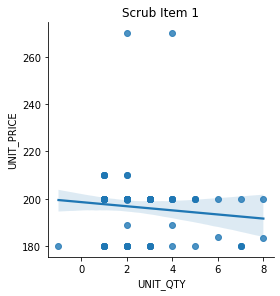

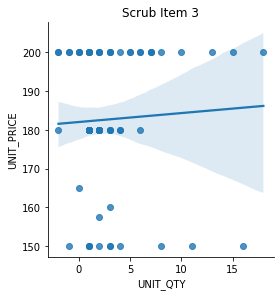

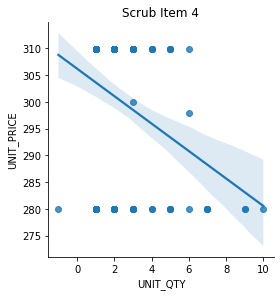

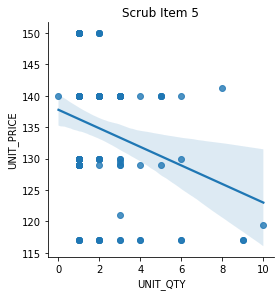

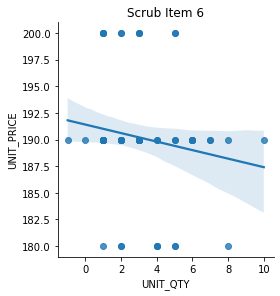

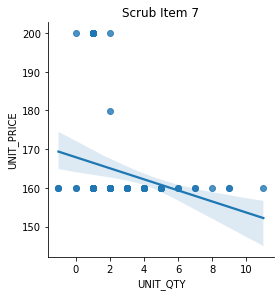

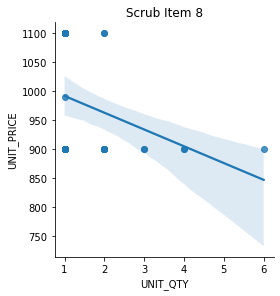

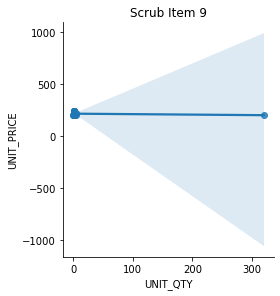

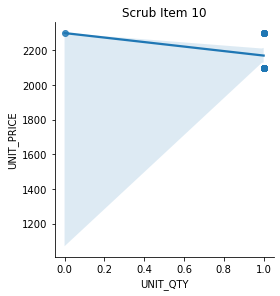

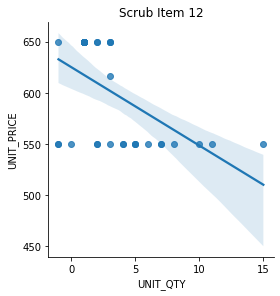

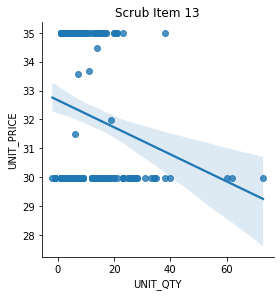

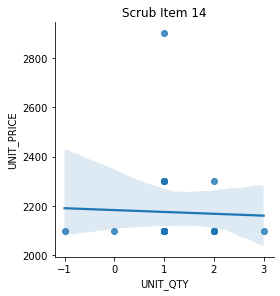

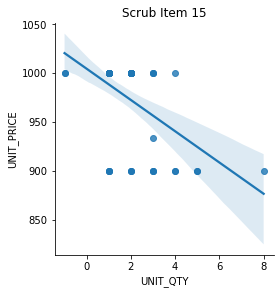

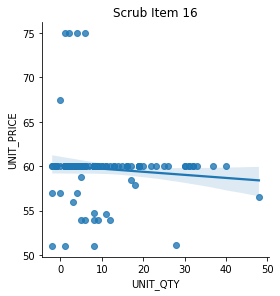

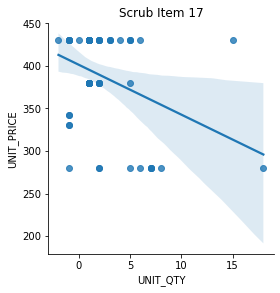

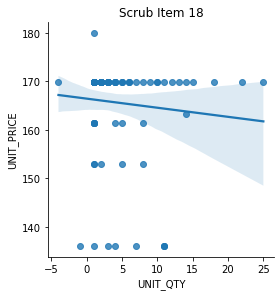

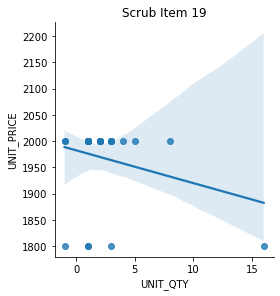

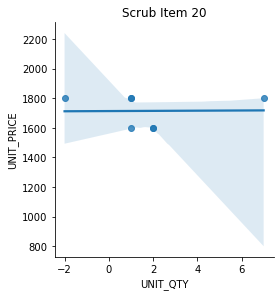

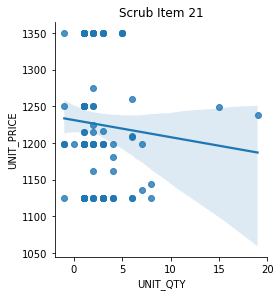

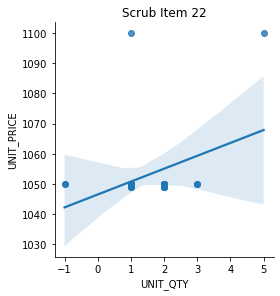

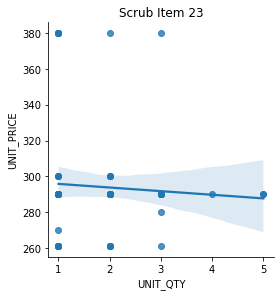

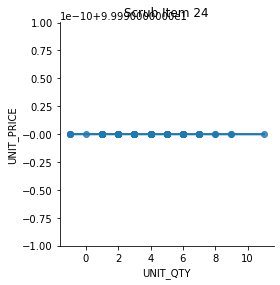

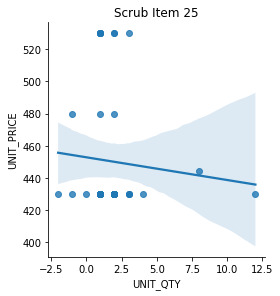

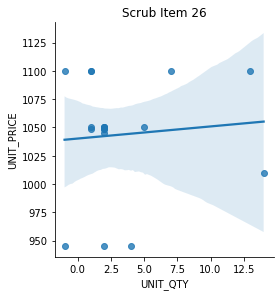

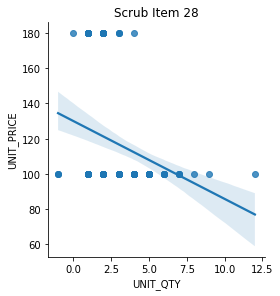

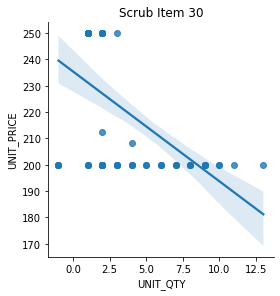

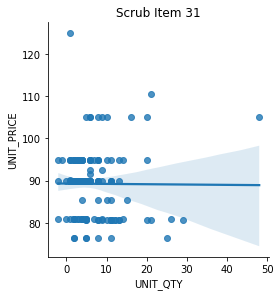

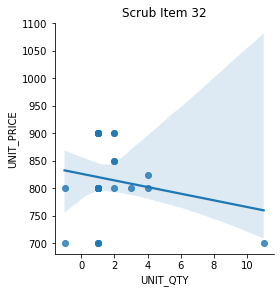

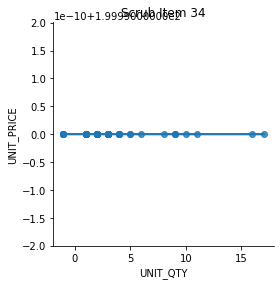

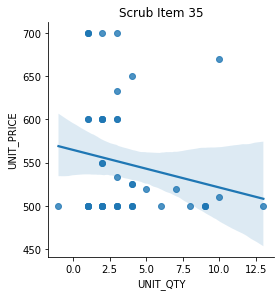

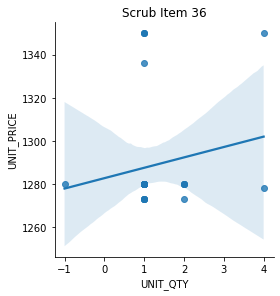

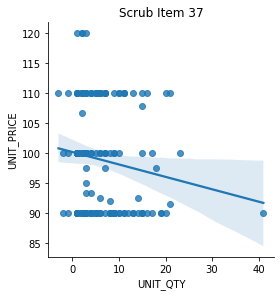

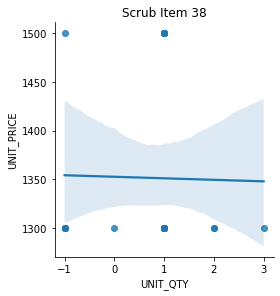

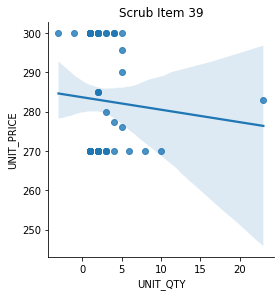

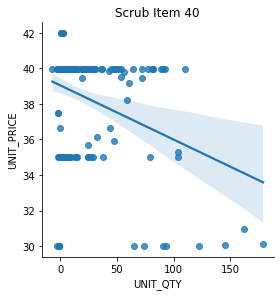

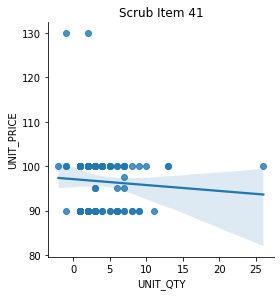

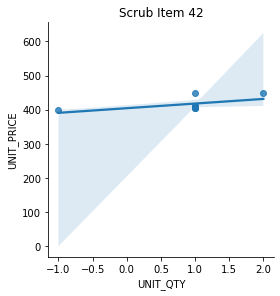

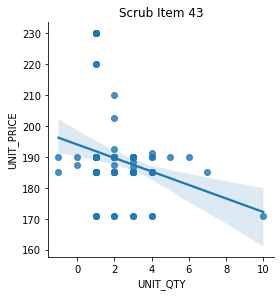

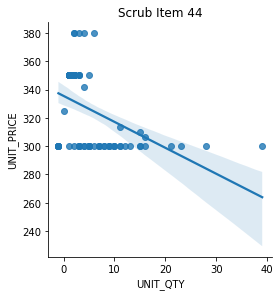

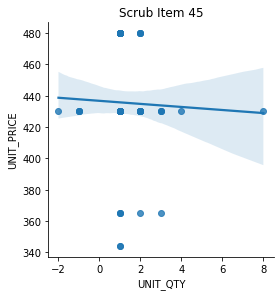

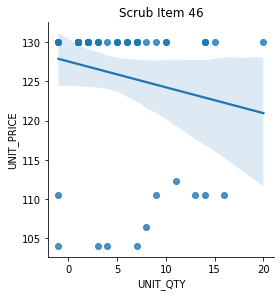

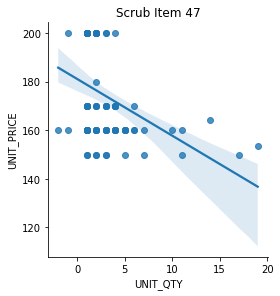

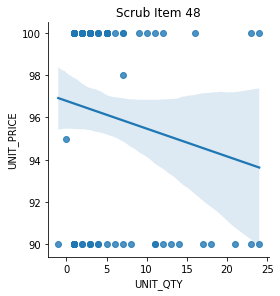

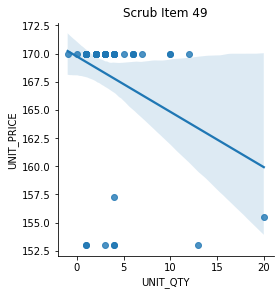

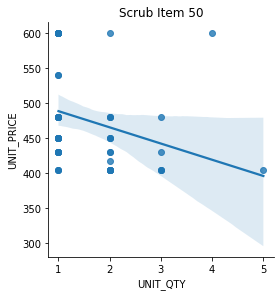

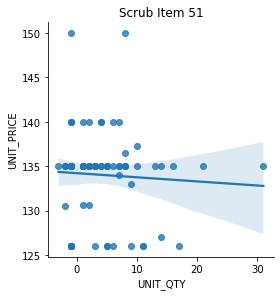

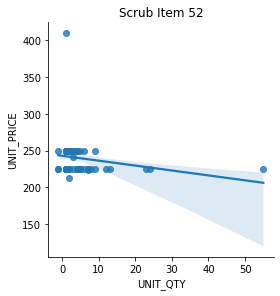

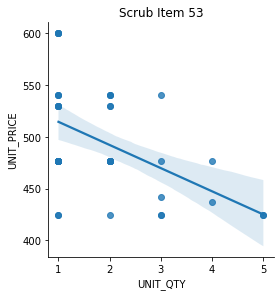

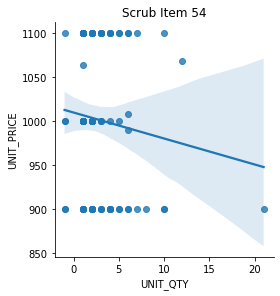

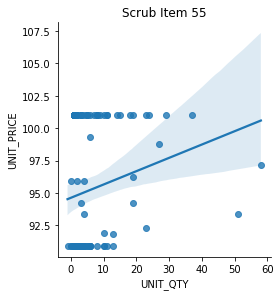

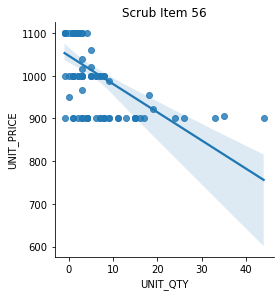

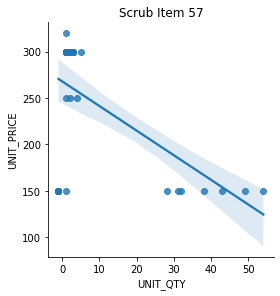

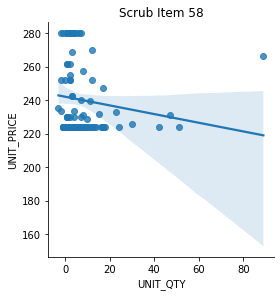

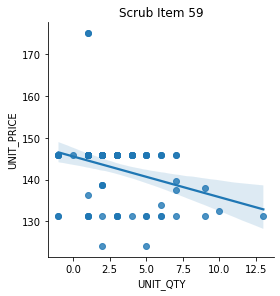

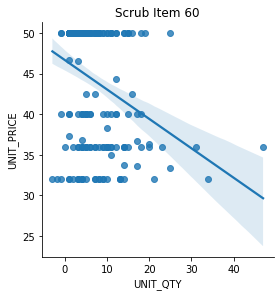

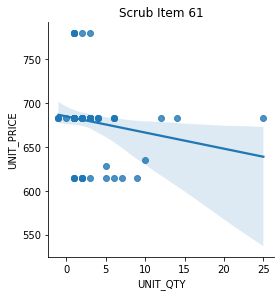

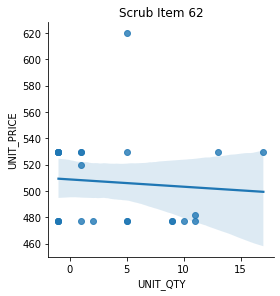

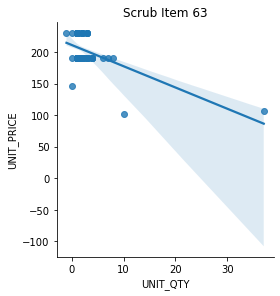

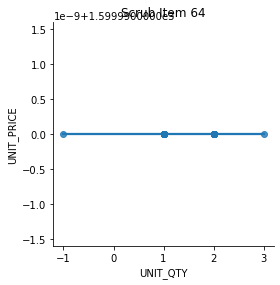

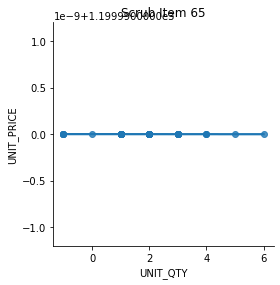

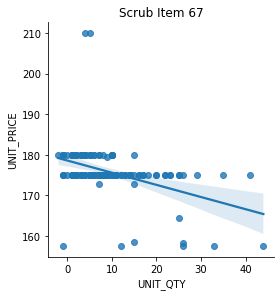

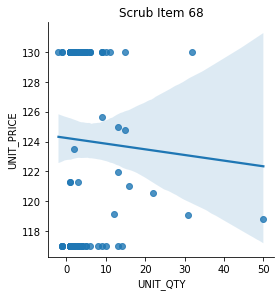

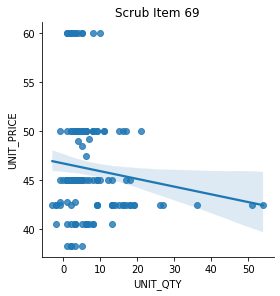

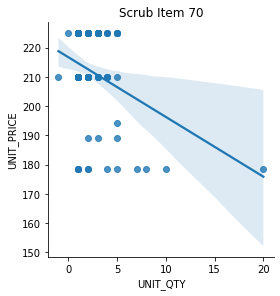

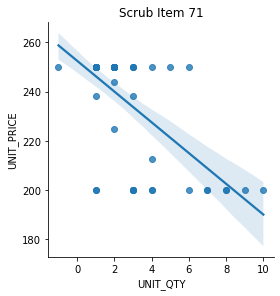

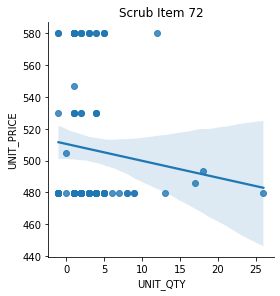

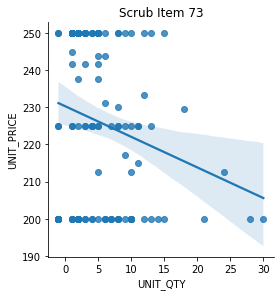

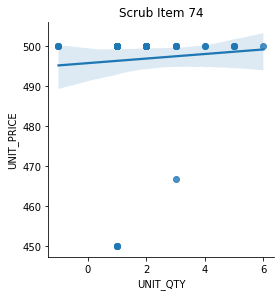

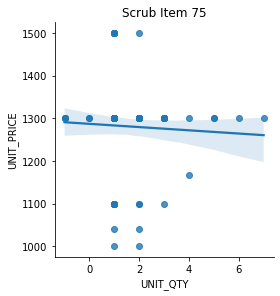

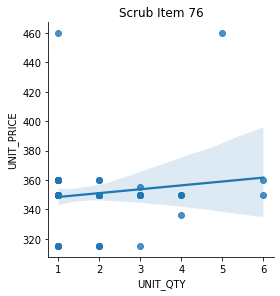

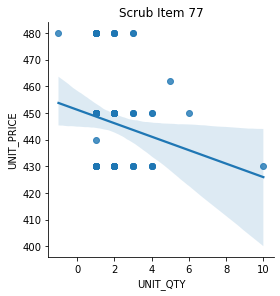

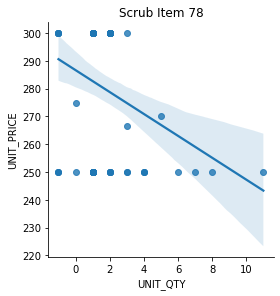

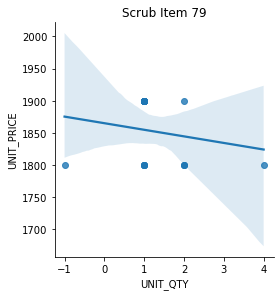

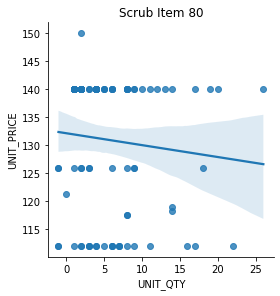

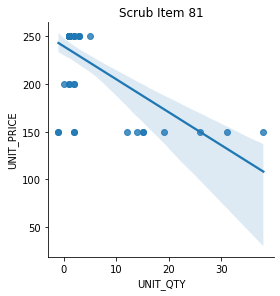

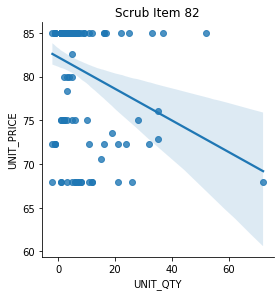

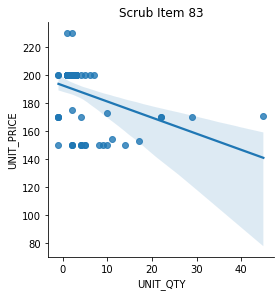

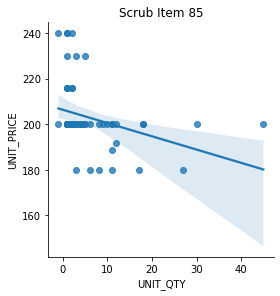

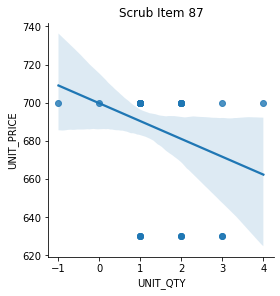

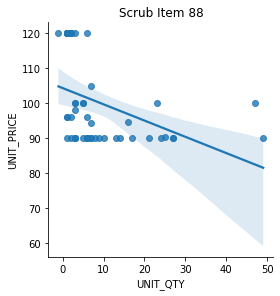

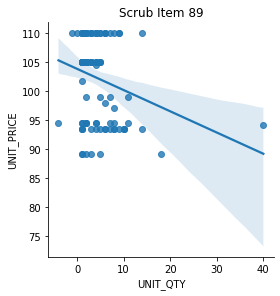

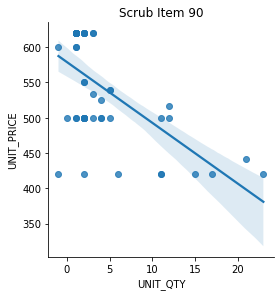

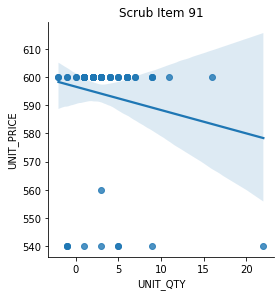

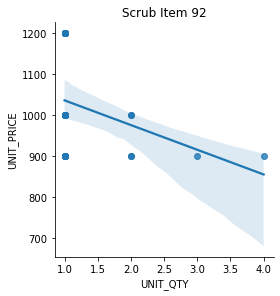

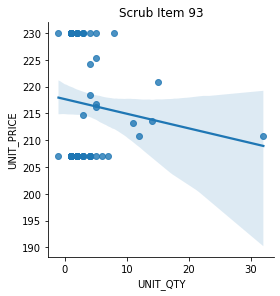

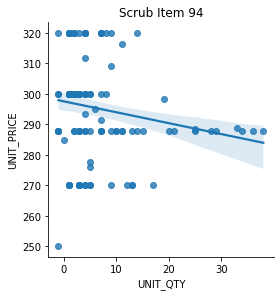

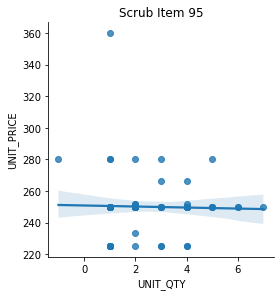

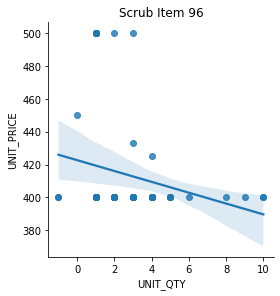

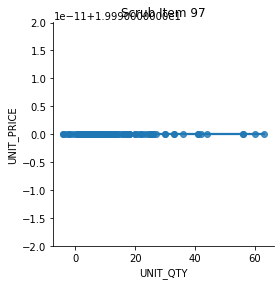

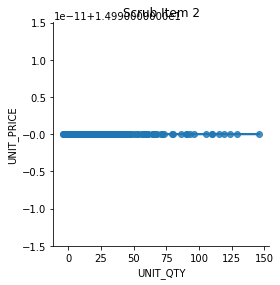

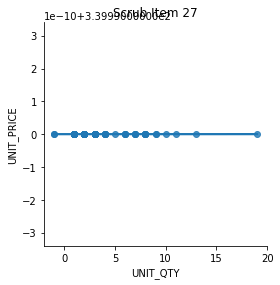

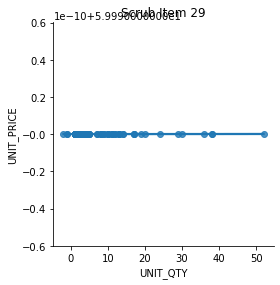

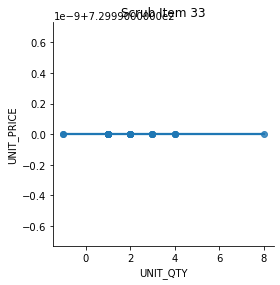

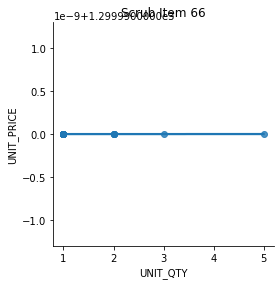

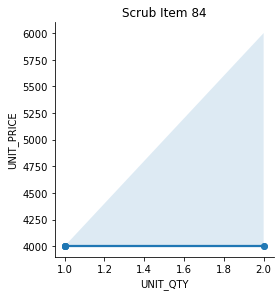

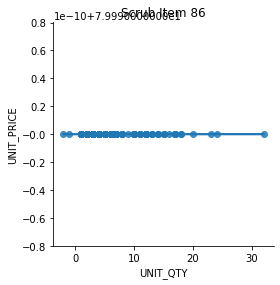

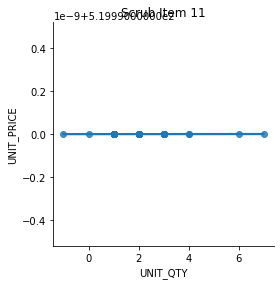

In [135]:
for i in items:
    df_item = df3[df3['SCRUB_ITEM']==i]
    sns.lmplot(x = "UNIT_QTY", y = "UNIT_PRICE", data =df_item , height = 4);
    ax = plt.gca();
    ax.set_title("Scrub Item {}".format(i));

## Rolling up to Months

In [80]:
df4 = df3.set_index('DATE')

In [81]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8649 entries, 2020-08-06 to 2021-07-23
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SCRUB_ITEM                  8649 non-null   int64  
 1   UNIT_QTY                    8649 non-null   float64
 2   UNIT_PRICE                  8649 non-null   float64
 3   AVG_COMPETITOR_TOTAL_PRICE  8649 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 337.9 KB


In [82]:
df5 = df4.groupby('SCRUB_ITEM').resample('M').agg({'UNIT_QTY':'sum',
                                             'UNIT_PRICE':'mean',
                                             'AVG_COMPETITOR_TOTAL_PRICE':'mean'}).ffill()

In [83]:
df5.reset_index(inplace=True)

In [84]:
df5['MONTH'] = df5['DATE'].dt.month
df5['YEAR'] = df5['DATE'].dt.year

In [85]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   SCRUB_ITEM                  1102 non-null   int64         
 1   DATE                        1102 non-null   datetime64[ns]
 2   UNIT_QTY                    1102 non-null   float64       
 3   UNIT_PRICE                  1102 non-null   float64       
 4   AVG_COMPETITOR_TOTAL_PRICE  1102 non-null   float64       
 5   MONTH                       1102 non-null   int64         
 6   YEAR                        1102 non-null   int64         
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 60.4 KB


In [86]:
df6 = df5.drop('DATE', axis=1)

## Adjusting Dataframe

In [87]:
df6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   SCRUB_ITEM                  1102 non-null   int64  
 1   UNIT_QTY                    1102 non-null   float64
 2   UNIT_PRICE                  1102 non-null   float64
 3   AVG_COMPETITOR_TOTAL_PRICE  1102 non-null   float64
 4   MONTH                       1102 non-null   int64  
 5   YEAR                        1102 non-null   int64  
dtypes: float64(3), int64(3)
memory usage: 51.8 KB


In [88]:
df6

,SCRUB_ITEM,UNIT_QTY,UNIT_PRICE,AVG_COMPETITOR_TOTAL_PRICE,MONTH,YEAR
0,1,7.0,199.990000,205.252000,8,2020
1,1,14.0,191.101111,200.673333,9,2020
2,1,30.0,199.990000,190.145000,10,2020
3,1,31.0,191.545556,191.300556,11,2020
4,1,32.0,184.990000,189.368333,12,2020
...,...,...,...,...,...,...
1097,97,321.0,19.990000,39.894286,4,2021
1098,97,310.0,19.990000,39.020000,5,2021
1099,97,160.0,19.990000,36.915000,6,2021
1100,97,175.0,19.990000,32.330000,7,2021


In [89]:
quant_25 = df6['UNIT_QTY'].quantile(0.25)
quant_75 = df6['UNIT_QTY'].quantile(0.75)
iqr = quant_75-quant_25

df6[df6['UNIT_QTY']> 3*iqr+quant_75].sort_values('UNIT_QTY', ascending=False)

,SCRUB_ITEM,UNIT_QTY,UNIT_PRICE,AVG_COMPETITOR_TOTAL_PRICE,MONTH,YEAR
453,40,1909.0,37.020022,48.760000,11,2020
19,2,1261.0,14.990000,22.299783,3,2021
21,2,1111.0,14.990000,22.628636,5,2021
452,40,1002.0,38.706795,47.985333,10,2020
15,2,632.0,14.990000,21.437632,11,2020
...,...,...,...,...,...,...
751,67,149.0,174.990000,219.103929,8,2020
419,37,146.0,91.656667,132.632187,12,2020
423,37,138.0,99.372353,113.521765,4,2021
769,68,137.0,124.576406,129.647188,4,2021


In [90]:
df6 = df6[df6['UNIT_QTY']<500]

## More EDA:

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


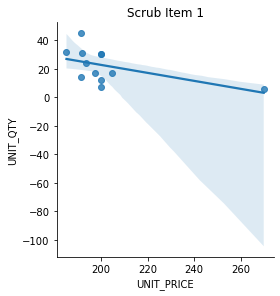

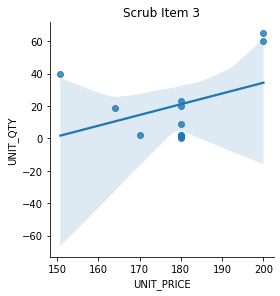

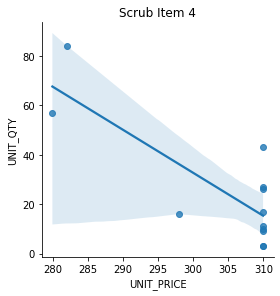

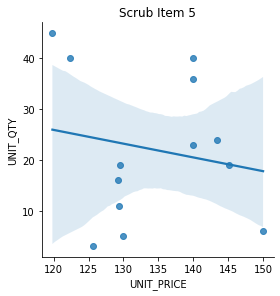

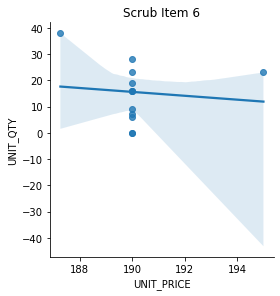

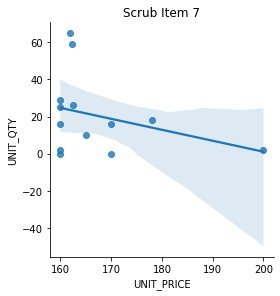

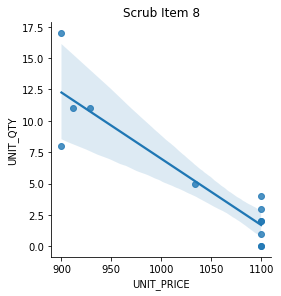

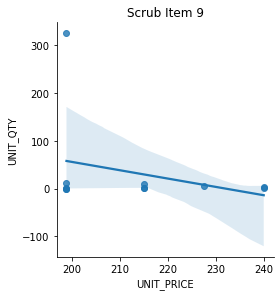

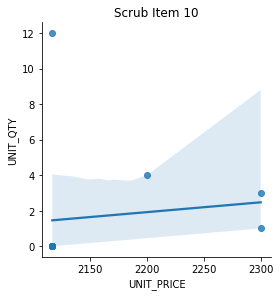

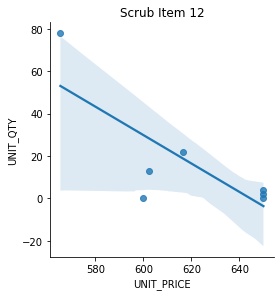

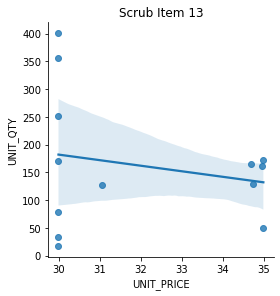

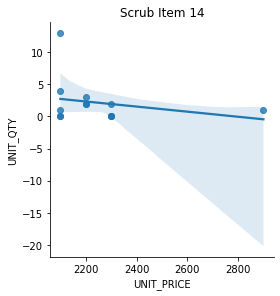

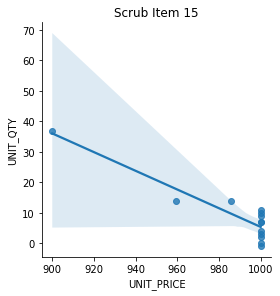

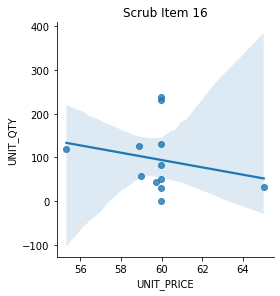

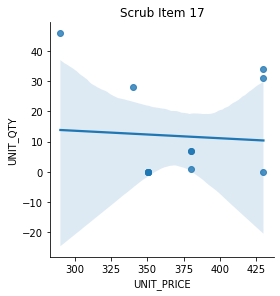

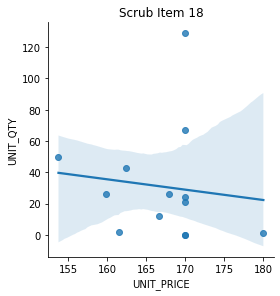

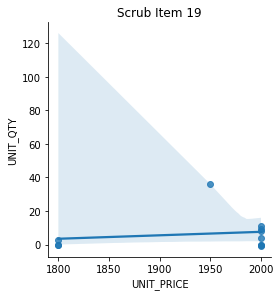

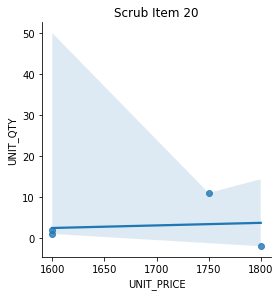

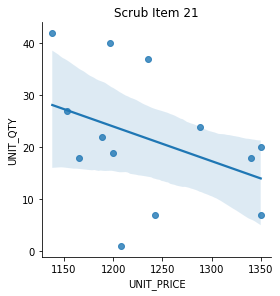

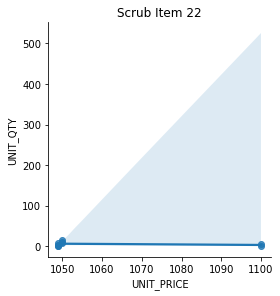

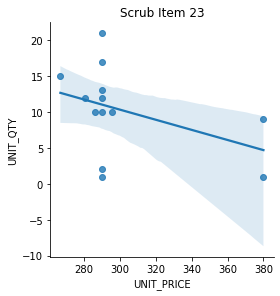

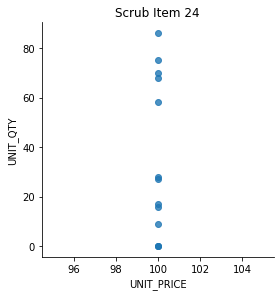

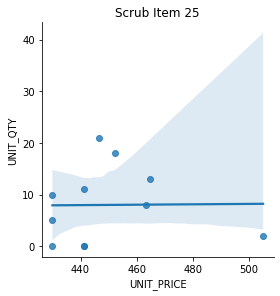

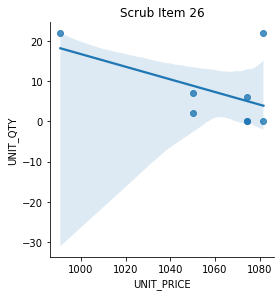

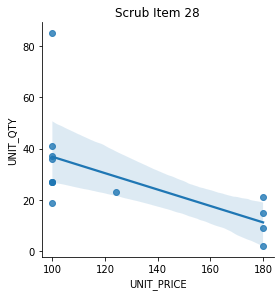

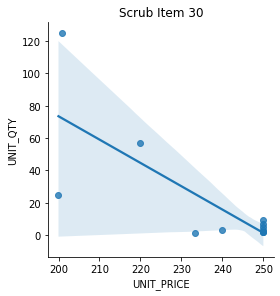

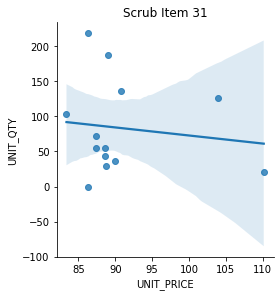

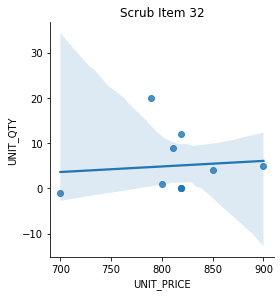

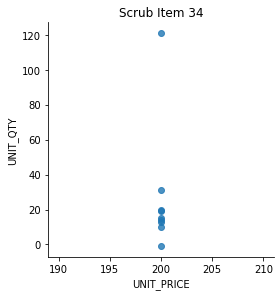

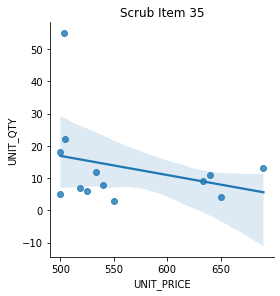

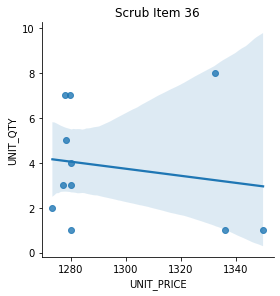

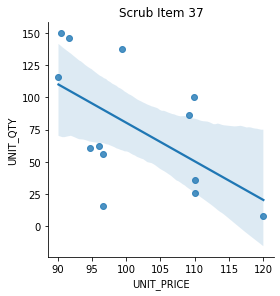

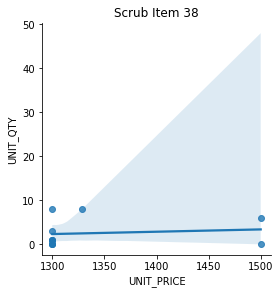

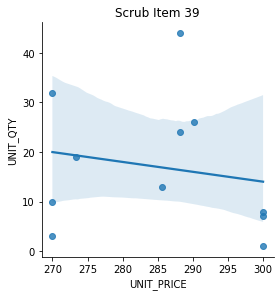

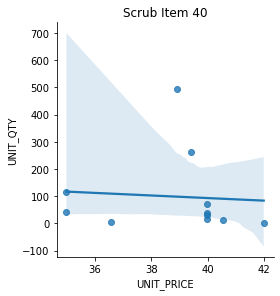

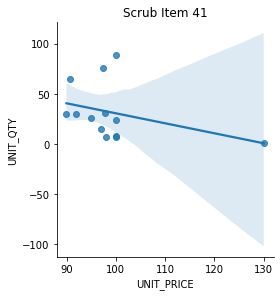

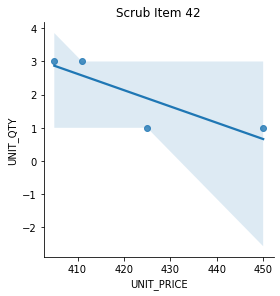

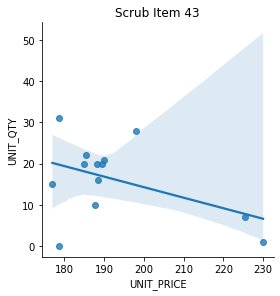

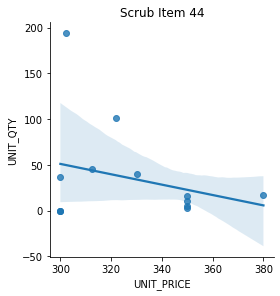

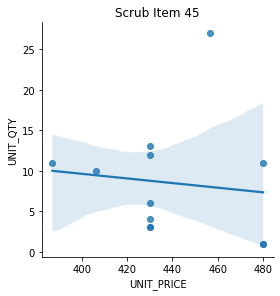

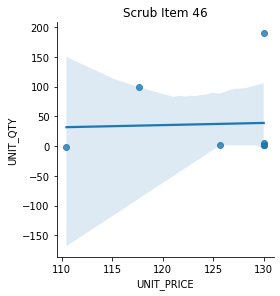

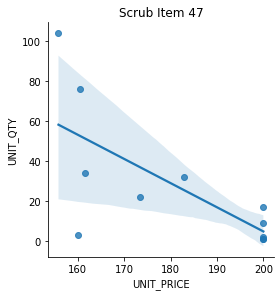

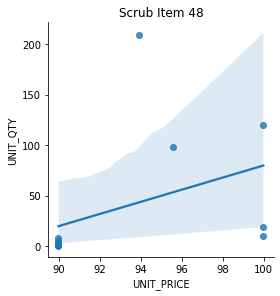

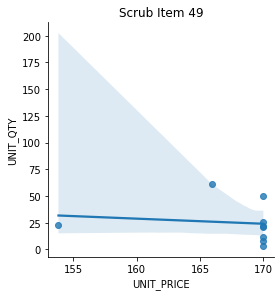

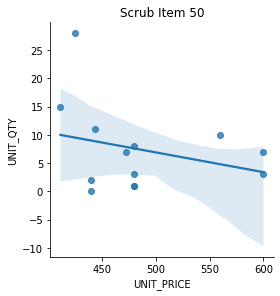

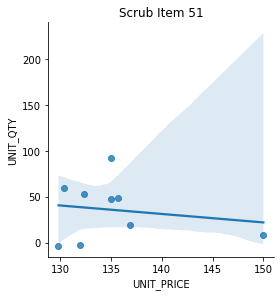

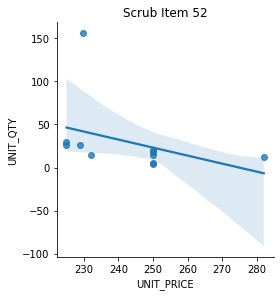

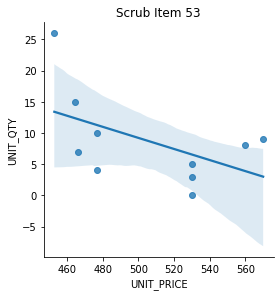

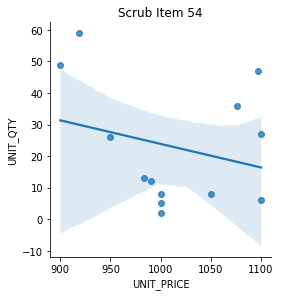

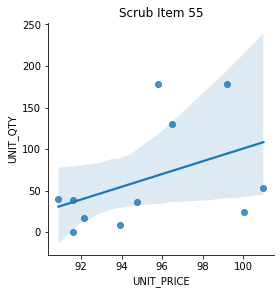

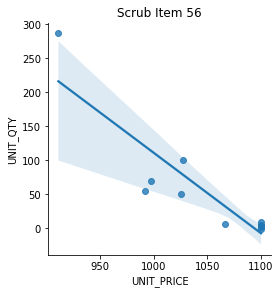

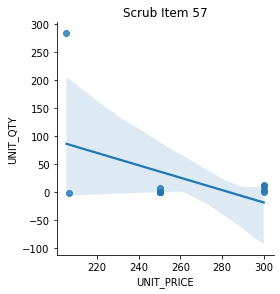

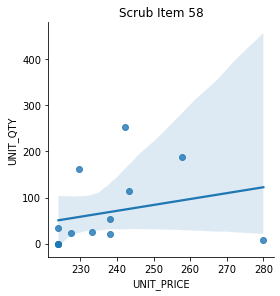

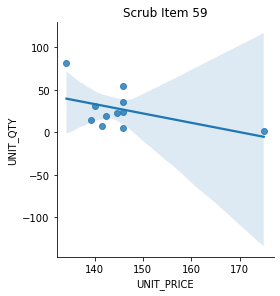

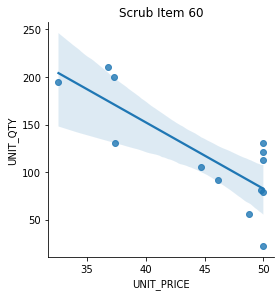

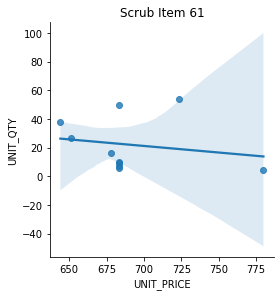

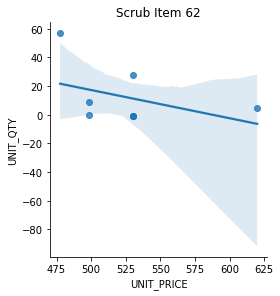

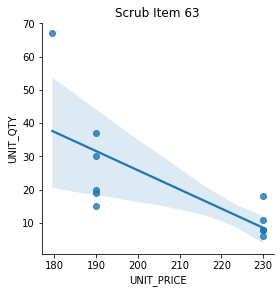

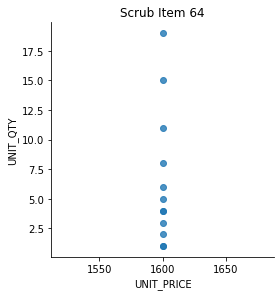

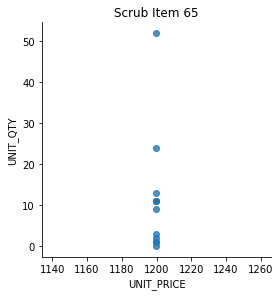

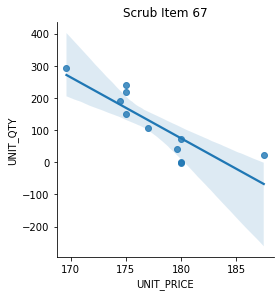

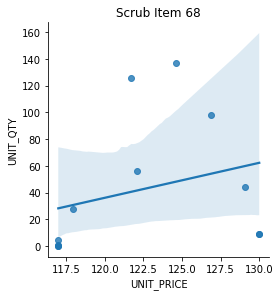

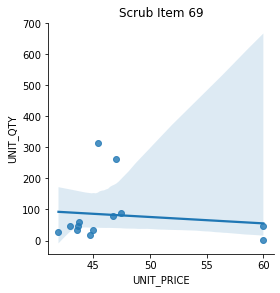

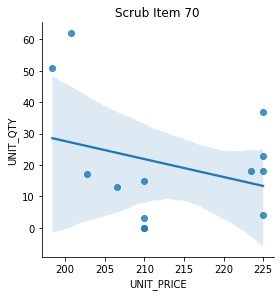

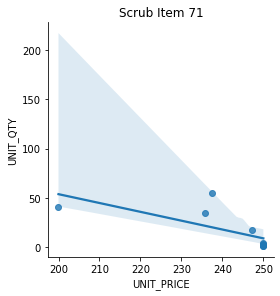

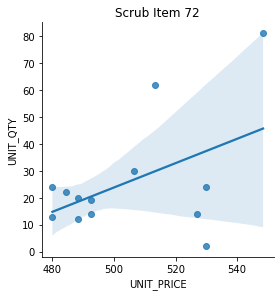

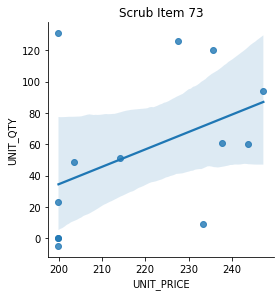

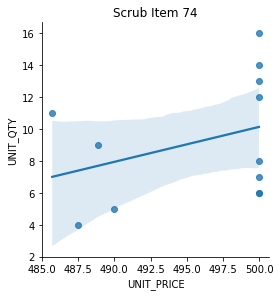

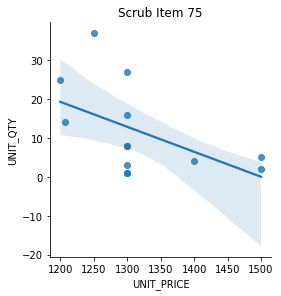

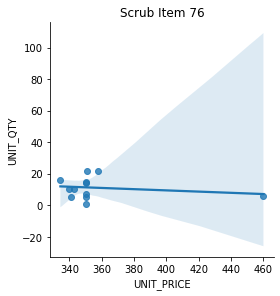

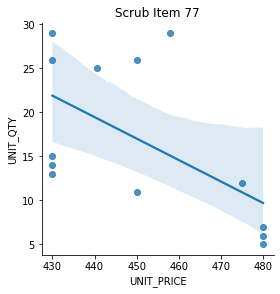

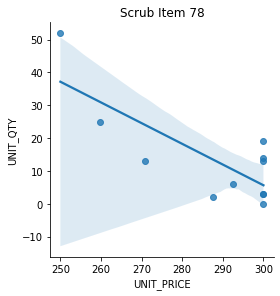

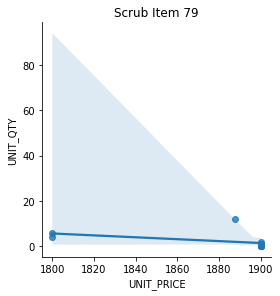

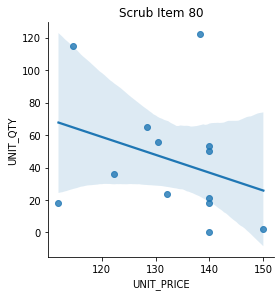

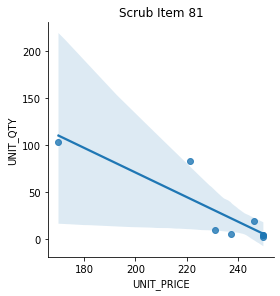

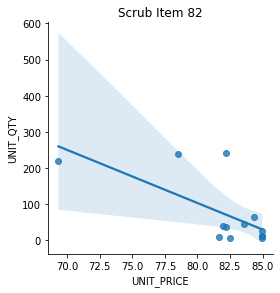

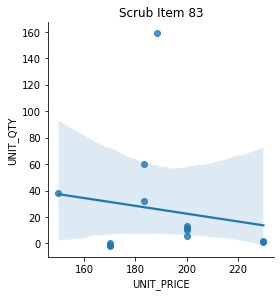

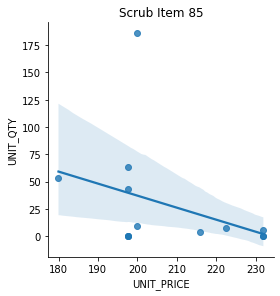

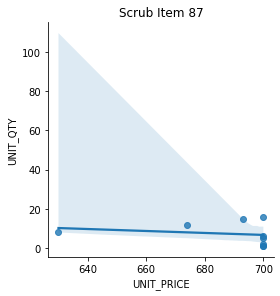

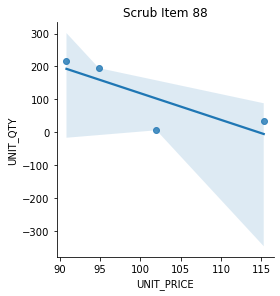

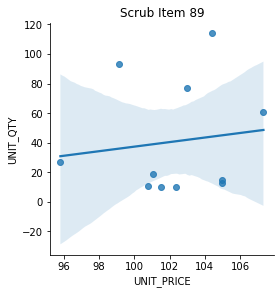

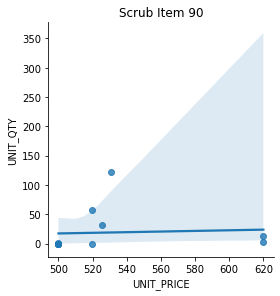

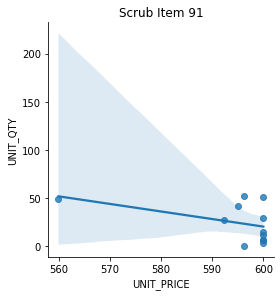

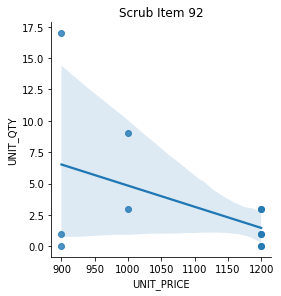

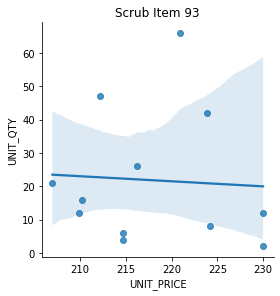

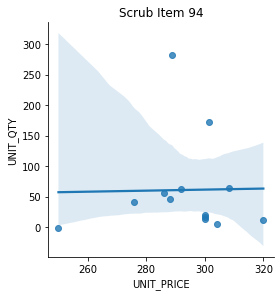

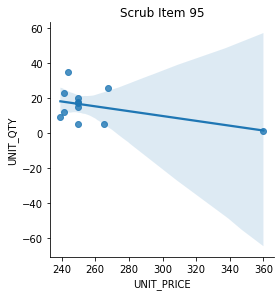

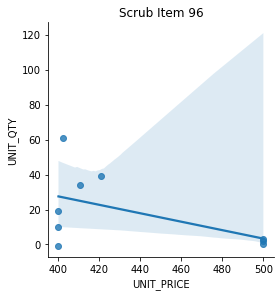

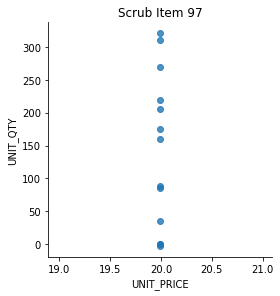

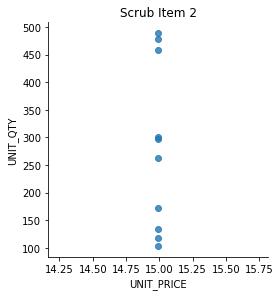

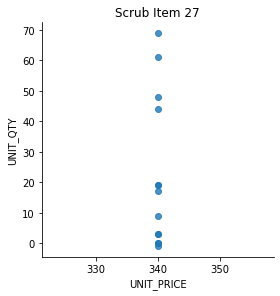

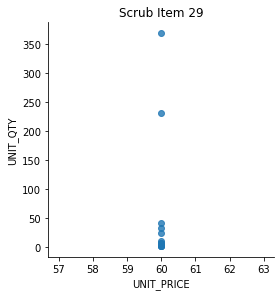

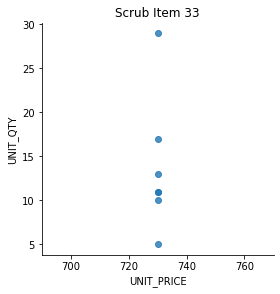

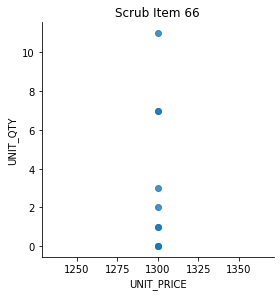

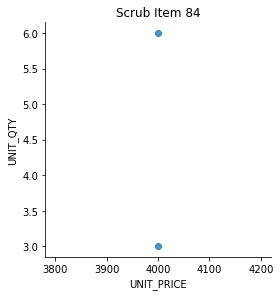

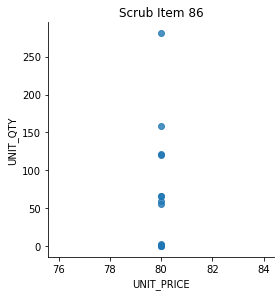

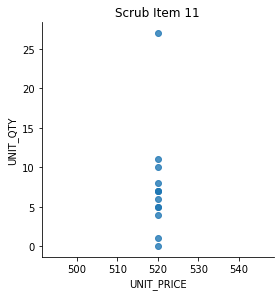

In [137]:
for i in items:
    df_item = df6[df6['SCRUB_ITEM']==i]
    sns.lmplot(x = "UNIT_PRICE", y = "UNIT_QTY", data =df_item , height = 4);
    ax = plt.gca();
    ax.set_title("Scrub Item {}".format(i));

## Modeling

### Initial Splits and Pipeline Parameters

In [91]:
X = df6.drop('UNIT_QTY', axis=1)
y = df6['UNIT_QTY']

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [93]:
X_cat_all = ['SCRUB_ITEM', 'MONTH']
X_cat_item = ['SCRUB_ITEM', 'MONTH']
X_num_all = X.drop(X_cat_all,axis=1).columns
X_num_item = X.drop(X_cat_item,axis=1).columns

In [94]:
#set up the column transfomer part of the pipeline
numTrans = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])
catTrans = Pipeline(steps=[
    ('ohe', OneHotEncoder(sparse=False,
                          handle_unknown='ignore'))
    ])

c_transform_all = ColumnTransformer(transformers=[
    ('num', numTrans, X_num_all),
    ('cat', catTrans, X_cat_all)
    ])

c_transform_item = ColumnTransformer(transformers=[
    ('num', numTrans, X_num_item),
    ('cat', catTrans, X_cat_item)
    ])

### Linear Regression - Scrub Item 1

In [ ]:
df

In [107]:
X_train, X_test, y_train, y_test = train_test_split_item(df6, 1, 'UNIT_QTY', test_size=0.5)

In [108]:
model1 = Pipeline(steps=[
    ('c_trans', c_transform_item),
    ('linreg', LinearRegression()) 
    ])

In [109]:
model1.fit(X_train, y_train)

Pipeline(steps=[('c_trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['UNIT_PRICE', 'AVG_COMPETITOR_TOTAL_PRICE', 'YEAR'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['SCRUB_ITEM', 'MONTH'])])),
                ('linreg', LinearRegression())])

In [110]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1,
                        X= X_train,
                        y=y_train,
                        random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

'The median R-squared values for the train sets were 1.0, the median R-squared values for the test sets were -0.083. These values resulted in a differential of 1.08317'

In [111]:
model1_scores = score_model(model1,
                            X_train,
                            X_test,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]),
                               model1_scores[2])
model1_summary

'The R-squared value for the train set was 1.0, and the R-squared value for the test set was -0.756. These values resulted in a differential of 1.75557. The RMSE of our model predicitons was 10.8'

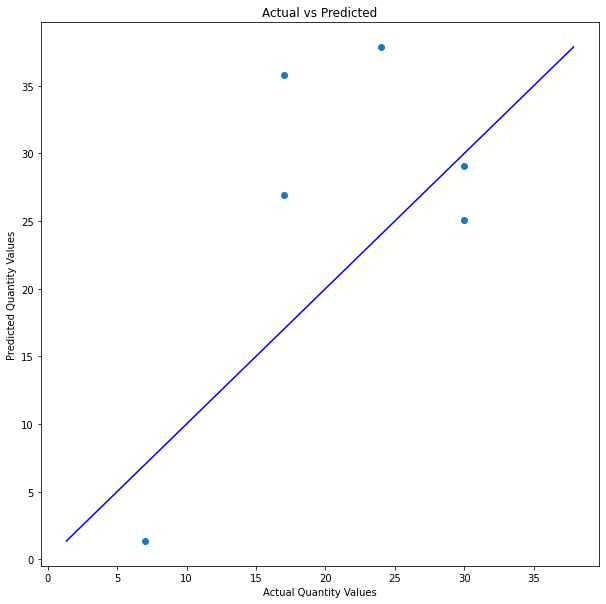

In [112]:
actual_vs_predicted(model1, X_test, y_test)

## Random Forest Regressor

In [113]:
model1 = Pipeline(steps=[
    ('c_trans', c_transform_item),
    ('randomforest', RandomForestRegressor()) 
    ])

In [114]:
model1.fit(X_train, y_train)

Pipeline(steps=[('c_trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['UNIT_PRICE', 'AVG_COMPETITOR_TOTAL_PRICE', 'YEAR'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['SCRUB_ITEM', 'MONTH'])])),
                ('randomforest', RandomForestRegressor())])

In [115]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1,
                        X= X_train,
                        y=y_train,
                        random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

'The median R-squared values for the train sets were 0.786, the median R-squared values for the test sets were -0.07. These values resulted in a differential of 0.85596'

In [116]:
model1_scores = score_model(model1,
                            X_train,
                            X_test,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]),
                               model1_scores[2])
model1_summary

'The R-squared value for the train set was 0.751, and the R-squared value for the test set was 0.04. These values resulted in a differential of 0.71073. The RMSE of our model predicitons was 7.99'

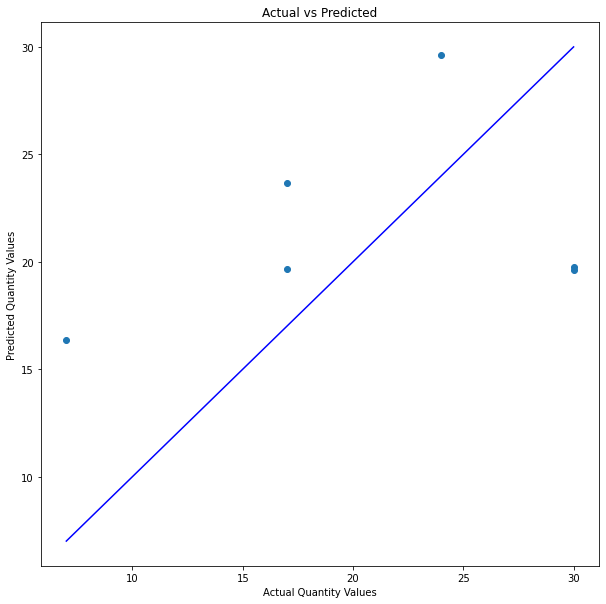

In [117]:
actual_vs_predicted(model1, X_test, y_test)

## KNN Regressor

In [118]:
model1 = Pipeline(steps=[
    ('c_trans', c_transform_item),
    ('knn', KNeighborsRegressor()) 
    ])

In [119]:
model1.fit(X_train, y_train)

Pipeline(steps=[('c_trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['UNIT_PRICE', 'AVG_COMPETITOR_TOTAL_PRICE', 'YEAR'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['SCRUB_ITEM', 'MONTH'])])),
                ('knn', KNeighborsRegressor())])

In [120]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1,
                        X= X_train,
                        y=y_train,
                        random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 397, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
  File "/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/utils/metaestimators.py", line 120, in <lambda>
    out = lambda *args, **kwargs: self.fn(obj, *args, **kwargs)
  File "/Users/arthur/opt/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/pipeline.py", line 622, in score
    return self.steps[-1][-1].score(Xt, y, **

'The median R-squared values for the train sets were nan, the median R-squared values for the test sets were nan. These values resulted in a differential of nan'

In [121]:
model1_scores = score_model(model1,
                            X_train,
                            X_test,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]),
                               model1_scores[2])
model1_summary

'The R-squared value for the train set was -0.062, and the R-squared value for the test set was -0.407. These values resulted in a differential of 0.34564. The RMSE of our model predicitons was 9.67'

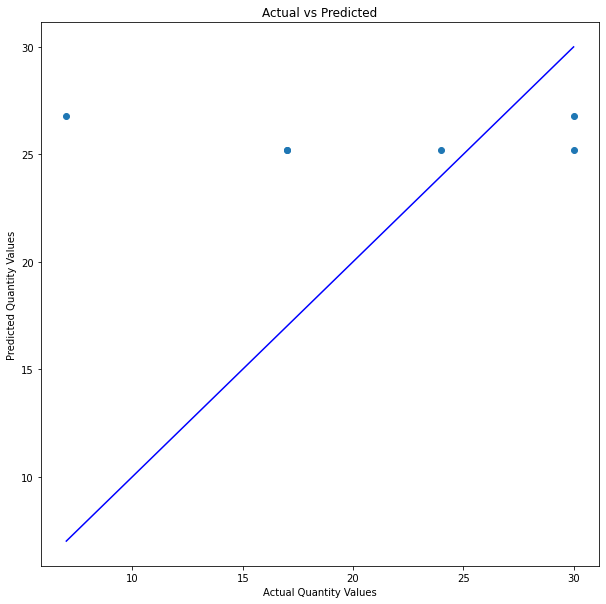

In [122]:
actual_vs_predicted(model1, X_test, y_test)

## Decision Tree Regressor

In [123]:
model1 = Pipeline(steps=[
    ('c_trans', c_transform_item),
    ('DT', DecisionTreeRegressor(max_depth=5)) 
    ])

In [124]:
model1.fit(X_train, y_train)

Pipeline(steps=[('c_trans',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['UNIT_PRICE', 'AVG_COMPETITOR_TOTAL_PRICE', 'YEAR'], dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['SCRUB_ITEM', 'MONTH'])])),
                ('DT', DecisionTreeRegressor(max_depth=5))])

In [125]:
#setting up cross validation for price in a different way 
model1_cval = cross_val(model1,
                        X= X_train,
                        y=y_train,
                        random_state=0)

model1_cval_summary = cval_summary(model1_cval[0],
                                   model1_cval[1],
                                   abs(model1_cval[0]-model1_cval[1]))
model1_cval_summary

'The median R-squared values for the train sets were 1.0, the median R-squared values for the test sets were -0.44. These values resulted in a differential of 1.43978'

In [126]:
model1_scores = score_model(model1,
                            X_train,
                            X_test,
                            y_train,
                            y_test)

model1_summary = model_summary(model1_scores[0],
                               model1_scores[1],
                               abs(model1_scores[0]-model1_scores[1]),
                               model1_scores[2])
model1_summary

'The R-squared value for the train set was 1.0, and the R-squared value for the test set was -1.919. These values resulted in a differential of 2.91851. The RMSE of our model predicitons was 13.93'

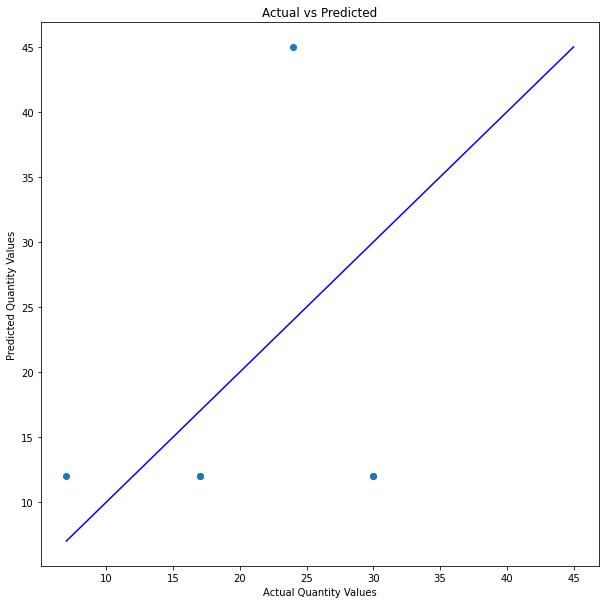

In [127]:
actual_vs_predicted(model1, X_test, y_test)